In [ ]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.3



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/2018-07 La Paz/Site 5/lap_2018-07_site05_120m_RGB_cc.tif" .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip /content/lap_2018-07_site05_120m_m-nm.zip

Archive:  /content/lap_2018-07_site05_120m_m-nm.zip
  inflating: lap_2018-07_site05_120m_m-nm_dissolve.dbf  
  inflating: lap_2018-07_site05_120m_m-nm_dissolve.prj  
  inflating: lap_2018-07_site05_120m_m-nm_dissolve.qpj  
  inflating: lap_2018-07_site05_120m_m-nm_dissolve.shp  
  inflating: lap_2018-07_site05_120m_m-nm_dissolve.shx  


In [ ]:
from gis_utils import raster

file = "lap_2018-07_site05_120m_RGB_cc.tif"
shapefile = "lap_2018-07_site05_120m_m-nm_dissolve.shp"
ortho,meta = raster.load_image(file)
tiles = raster.retile(ortho, meta, width = 1024, height = 1024)

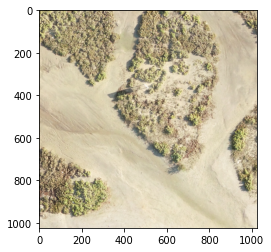

In [ ]:
from rasterio.plot import reshape_as_image
from matplotlib.pyplot import imshow
%matplotlib inline

tile = reshape_as_image(tiles[100])
imshow(tile)

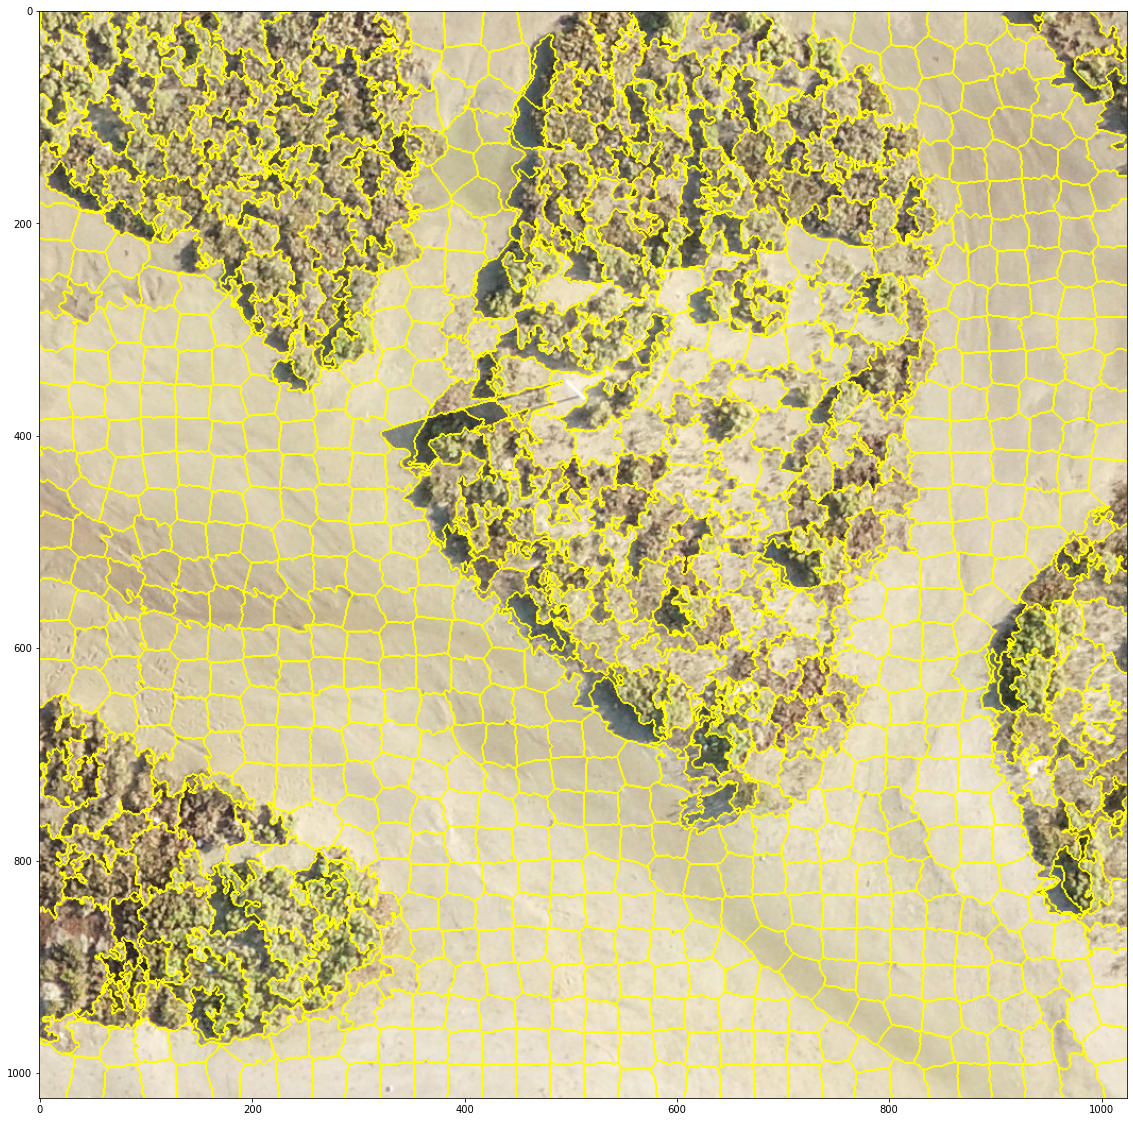

In [ ]:
from matplotlib import pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic

img = tile[:,:,0:3]

segments_slic = slic(img, n_segments=1000, compactness=10, sigma=1)
plt.figure(figsize = (20,20))
imshow(mark_boundaries(img, segments_slic))

In [ ]:
import scipy
import numpy as np
from tqdm.autonotebook import tqdm

def get_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + [stats.mean, stats.variance, stats.skewness, stats.kurtosis]
        if npixels == 1:
            band_stats[3] = 0.0
        features.extend(band_stats) 
    return features


def get_objects(img, segments):
    segment_ids = np.unique(segments)
    objects = []
    object_ids = []
    for id in tqdm(segment_ids):
        segment_pixels = img[segments == id]
        object_features = get_features(segment_pixels)
        objects.append(object_features)
        object_ids.append(id)
    return objects, object_ids
    

In [ ]:
objects, object_ids = get_objects(img, segments_slic)

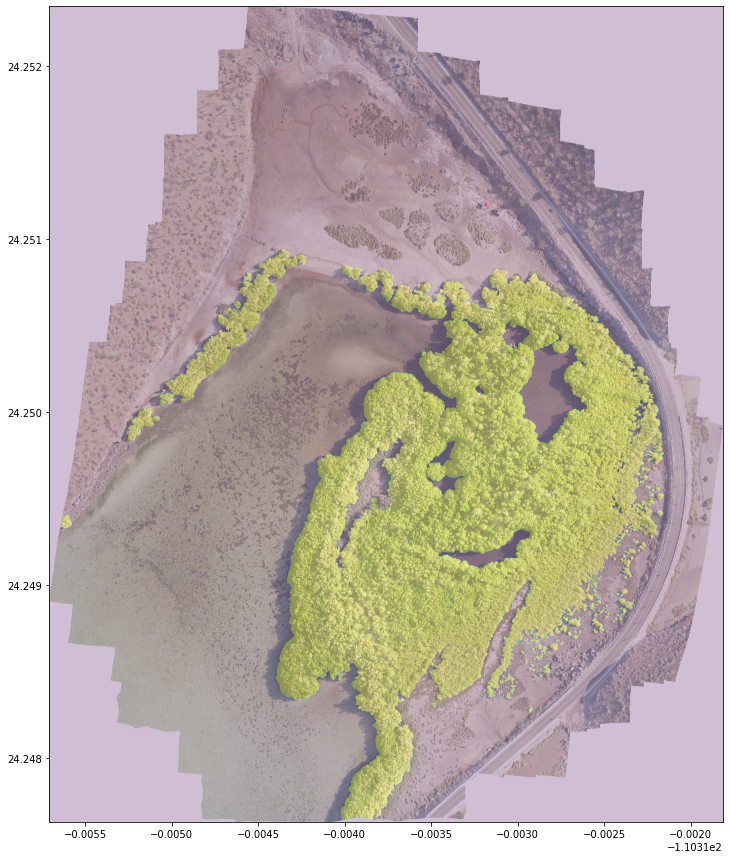

In [ ]:
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.plot import show

shp = gpd.read_file(shapefile)


def rasterize(shp,img,meta,geometry="geometry",label="label"):
    size = (img.height,img.width)
    out_array = np.zeros(size)
    shapes = ((geom,value) for geom, value in zip(shp[geometry], shp[label]))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_array, transform=img.transform)

    return burned

rasterized = rasterize(shp,ortho,meta)

#confirming that 
fig, ax = plt.subplots(figsize=(15, 15))
show(rasterized,ax=ax,alpha=0.5,transform=ortho.transform)
show(ortho,ax=ax,alpha=0.5)

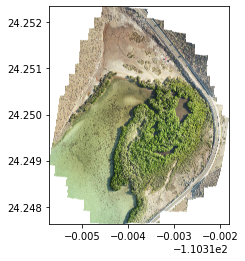